In [38]:
from hamming import hamming_allvall, hamming
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np

## 1. Create a multiple sequence alignment

Here, we've already computed the multiple sequence alignment and converted it to a csv.

In [16]:
X_df = pd.read_csv('./alignments/alignbio2023_invitro_msa.csv')

## 2. Compute all-v-all hamming distance matrix

In [6]:
X = hamming_allvall(X_df)

completed: 0 out of 1082 sequences
completed: 200 out of 1082 sequences
completed: 400 out of 1082 sequences
completed: 600 out of 1082 sequences
completed: 800 out of 1082 sequences
completed: 1000 out of 1082 sequences


## 3. Embed in 2D via MDS

For a given set of D datapoints of M-dimensions, MDS yields a set of D embedded points in N-dimensions <br>
 s.t. distances between embedded points preserve the distances between the original datapoints.

 Commonly, the distance is defined as Euclidean distance. <br>
 Here, we define hamming distance as the datapoint distance, and Euclidean distance as the embedding distance. <br>
 Therefore, our 2-D embedding gives Euclidean distances between points that approximate the hamming distance between the corresponding sequences.

 We take advantage of an existing MDS algorithm that finds the embedding points, and simply provide the hamming distances as a pre-computed DxD matrix.

Note: The MDS algorithm will return slightly different solutions unless a random seed is specified. <br>
The biggest difference is typically the global rotation.

In [7]:
embedding = MDS(n_components=2, normalized_stress='auto',dissimilarity = 'precomputed')
X_transformed = embedding.fit_transform(X)

## 4. Interpret and visualize the 2D embeddings

In [21]:
# To map mutation number to hamming fraction, use the ungapped target length
wt_seq = X_wt.aln.iloc[0].replace('-','')
print(len(X_wt.aln.iloc[0].replace('-','')), wt_seq)

425 LTAPSIKSGTILHAWNWSFNTLKHNMKDIHDAGYTAIQTSPINQVKEGNQGDKSMSNWYWLYQPTSYQIGNRYLGTEQEFKEMCAAAEEYGIKVIVDAVINHTTSDYAAISNEVKSIPNWTHGNTPIKNWSDRWDVTQNSLSGLYDWNTQNTQVQSYLKRFLDRALNDGADGFRFDAAKHIELPDDGSYGSQFWPNITNTSAEFQYGEILQDSVSRDAAYANYMDVTASNYGHSIRSALKNRNLGVSNISHYAVDVSADKLVTWVESHDTYANDDEESTWMSDDDIRLGWAVIASRSGSTPLFFSRPEGGGNGVRFPGKSQIGDRGSALFEDQAITAVNRFHNVMAGQPEELSNPNGNNQIFMNQRGSHGVVLANAGSSSVSINTATKLPDGRYDNKAGAGSFQVNDGKLTGTINARSVAVLYPD


### Find meaningful positions and distances in the 2-D space

In [51]:
# Get the 2-D position of the wildtype point
X_wt = X_df[X_df['team detail'].eq('control')]
i = X_wt.index[0]
wt_coord = X_transformed[i]

# Get the 2-D position of the alternative design starting point used by Rost lab
X_iff1 = X_df[X_df['team detail'].eq('IFF top #1')]
i = X_iff1.index[0]
iff1_coord = X_transformed[i]

# Compute distance of each sequence from alpha-amylase wildtype
X_df['h_wt'] = X_df.aln.apply(lambda x:hamming(x, X_wt.aln.iloc[0]))
X_df['h_iff1'] = X_df.aln.apply(lambda x:hamming(x, X_iff1.aln.iloc[0]))

# Get distance in 2-D corresponding to 10 mutations from wildtype
def euclidean(x1,x2):
    return np.sqrt(np.sum((x1-x2)**2, axis=-1))

i = X_df[X_df['h_wt'].eq(10/425)].index
d10 = np.mean(euclidean(wt_coord, X_transformed[i,:]))
i = X_df[X_df['h_wt'].between(49/425,51/425)].index
d50 = np.mean(euclidean(wt_coord, X_transformed[i,:]))
i = X_df[X_df['h_wt'].between(99/425, 101/425)].index
d100 = np.mean(euclidean(wt_coord, X_transformed[i,:]))

# Get distance in 2-D corresponding to 4 mutations from alternative design starting point
i = X_df[X_df['h_iff1'].eq(4/425)].index
d4 = np.mean(euclidean(iff1_coord, X_transformed[i,:]))


### Determine coloring for teams, and international flavors and fragrances (IFF) single and multi-mutants.

In [39]:
# List teams
team_map = {k:i for i,k in enumerate(X_df.team.drop_duplicates())}
leg = list(team_map.keys())#[::-1]

# Coloring specifications
singles_color = 'dimgray'
iff_color = 'indigo'
team_colors = {'singles': singles_color, 'singles top': singles_color, 'singles all-positive': singles_color,
               'IFF': iff_color, 'IFF top': iff_color, 'IFF all-positive': iff_color, 'IFF top #1': iff_color,
               'control':'black',
              'marks': 'darkorange'}

# Color by team

c = X_df.team.map(team_map)
X_df['c']  = c/c.max()
z = matplotlib.colormaps['tab20']
X_df['rgba'] = [tuple(a) for a in z(X_df['c'])]

### Plot, colored by team, and drawing circles around meaningful sequence distances.

/var/folders/zq/rff3g4rj5h3glfg7541rq67r0000gn/T/ipykernel_80996/4018613527.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(X_transformed[i,0], X_transformed[i,1],


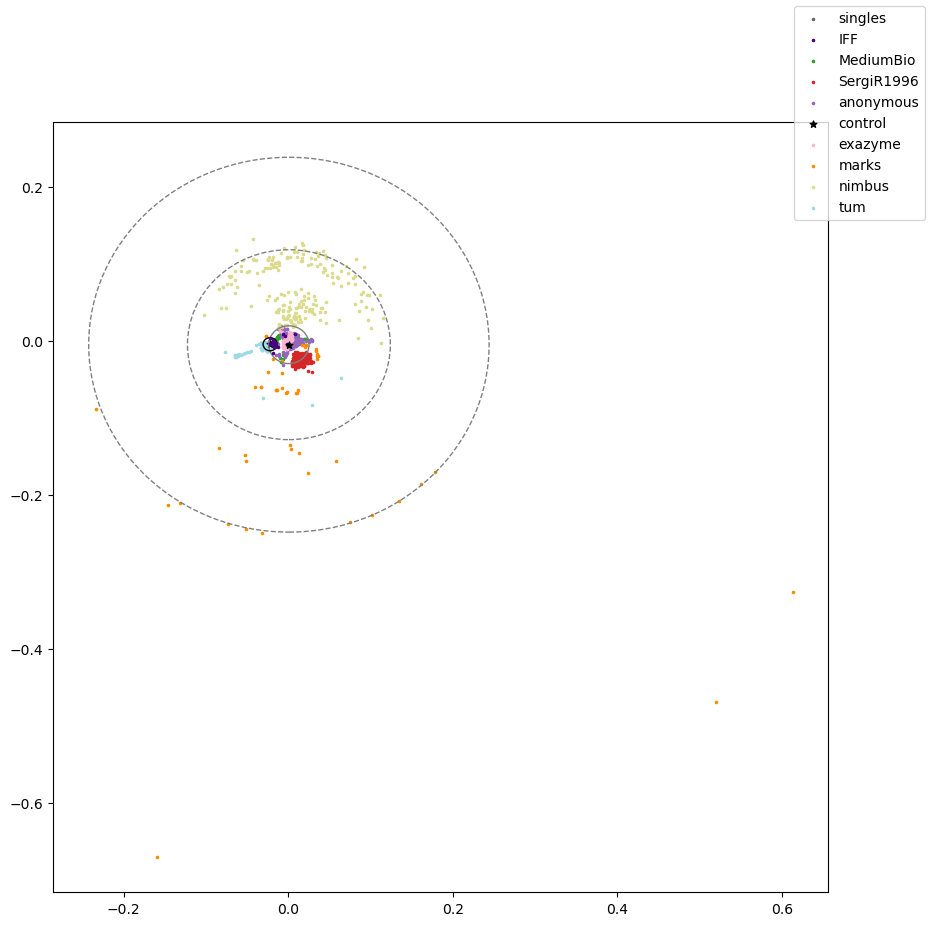

In [52]:
%matplotlib inline

def myplot():
    f, ax = plt.subplots(figsize=(10,10))
    for t in leg:
        Xf = X_df[X_df.team.eq(t)] # & (X_df['H'].isin([0,10]) | X_df['team'].eq('IFF top #1'))]
        i = list(Xf.index)
        
        ax.scatter(X_transformed[i,0], X_transformed[i,1],
                c=Xf.rgba.iloc[0] if t not in team_colors else team_colors[t],
                marker = '*' if t in ['IFF top #1', 'control'] else '.',
                s=25 if t=='control' else 10,
                zorder = 10 if t in ['control','singles','IFF','IFF top #1'] else 1,
            )
    f.legend(leg)


    d10 = 0.0245
    circle1 = plt.Circle(wt_coord, d10, edgecolor='gray', facecolor='none')
    circle2 = plt.Circle(iff1_coord, d4, edgecolor='black', facecolor='none')
    circle3 = plt.Circle(wt_coord, d50, edgecolor='gray', facecolor='none', ls='--', lw=1)
    circle4 = plt.Circle(wt_coord, d100, edgecolor='gray', facecolor='none', ls='--', lw=1)

    ax.scatter([iff1_coord[0]],[iff1_coord[1]], s=25, marker='*', c='k')
    ax.add_patch(circle1)
    ax.add_patch(circle2)
    ax.add_patch(circle3)
    ax.add_patch(circle4)

myplot()

### Zoom-in

/var/folders/zq/rff3g4rj5h3glfg7541rq67r0000gn/T/ipykernel_80996/4018613527.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(X_transformed[i,0], X_transformed[i,1],


(-0.04, 0.04)

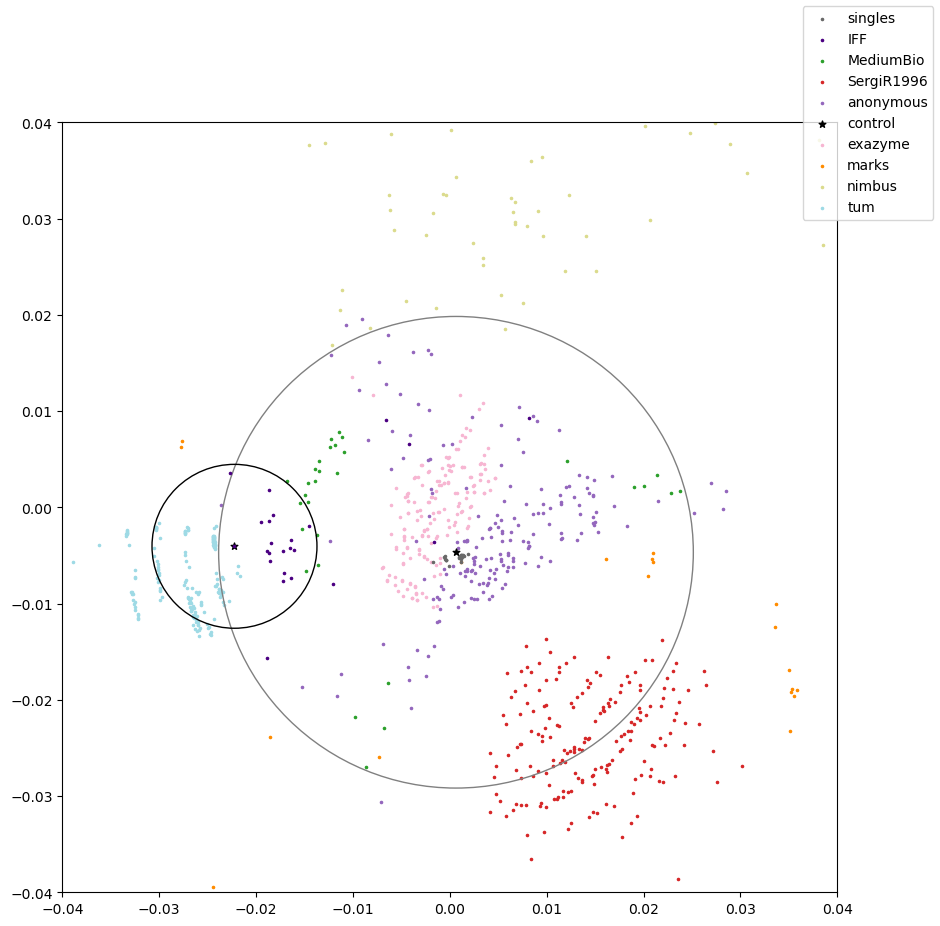

In [53]:
myplot()
plt.gca().set_xlim(-0.04,0.04)
plt.gca().set_ylim(-0.04,0.04)